# Data 처리

In [121]:
log_file = './log_fastapi_vllm_mistral7b0.2_50users.out'

In [123]:
import pandas as pd
from datetime import datetime

log_df = pd.read_csv(log_file,
                     delimiter=' \|\| ',
                     names=['epoch_time', 'user_Id', 'message1', 'message2'],)
# sorted_df = log_df.sort_values(by=['user_Id', 'epoch_time'])

userIds: list[str] = log_df["user_Id"].unique()

caculated_df_columns = ['userId', 'epoch_time', 'start_time', 'end_time', 'latency', 'ttft', 'tpot_avg', 'tpot_std', 'num_of_tokens', 'tokens_per_sec']
caculated_df = pd.DataFrame(columns=caculated_df_columns)

for userId in userIds:
    df = log_df[log_df['user_Id'] == userId]

    start_time = df.iloc[1]['epoch_time']
    end_time = df.iloc[-1]['epoch_time']

    latency = (end_time - start_time) / 1000

    ttft = df.iloc[2]['epoch_time'] - df.iloc[1]['epoch_time']
    time_differences = df['epoch_time'].diff()[1:]
    tpot_avg = time_differences.mean()
    tpot_std = time_differences.std()

    num_of_tokens = len(df[df['message1'].str.contains('Token received :') == True].index)

    data = {'userId': userId, 'epoch_time': end_time, 'start_time': start_time, 'end_time': end_time, 'latency': latency, 'ttft': ttft, 'tpot_avg': tpot_avg, 'tpot_std': tpot_std, 'num_of_tokens': num_of_tokens, 'tokens_per_sec': num_of_tokens / latency}

    caculated_df.loc[len(caculated_df)] = data

caculated_df = caculated_df.sort_values(by=['epoch_time'])

rampup_sequence_df = log_df[log_df['message1'].str.contains('CurrentUserCount') == True][['epoch_time', 'message2']]
rampup_sequence_df = rampup_sequence_df.sort_values(by=['epoch_time'])
rampup_sequence_df = rampup_sequence_df.rename(columns={'message2': 'UserCount'})
rampup_sequence_df['UserCount'] = rampup_sequence_df['UserCount'].map(lambda x: int(x))

caculated_df['Datetime(KST)'] = caculated_df['epoch_time'].map(lambda x: datetime.fromtimestamp(x / 1000))
rampup_sequence_df['Datetime(KST)'] = rampup_sequence_df['epoch_time'].map(lambda x: datetime.fromtimestamp(x/1000))


/var/folders/09/nrd0f7kd5rj1ds8c7s02dwwr16q1m1/T/ipykernel_92390/2059513538.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  log_df = pd.read_csv(log_file,


# 결과 출력

In [ ]:
import matplotlib

rampup_sequence_df.plot(title='User Rampup', figsize=(15, 3),
                        xlabel = 'Datetime(KST)', x='Datetime(KST)',
                        y=['UserCount'])


<Axes: title={'center': 'Tokens per second (per request)'}, xlabel='Datetime(KST)'>

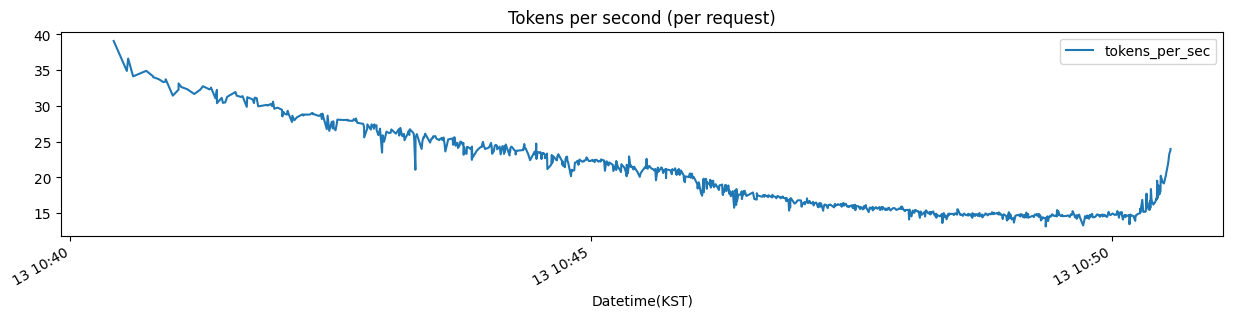

In [134]:
caculated_df.plot(title='Tokens per second (per request)', figsize=(15, 3),
                xlabel = 'Datetime(KST)', x='Datetime(KST)',
                y=['tokens_per_sec'])


<Axes: title={'center': 'TPOT(time per output token / ms)'}, xlabel='Datetime(KST)'>

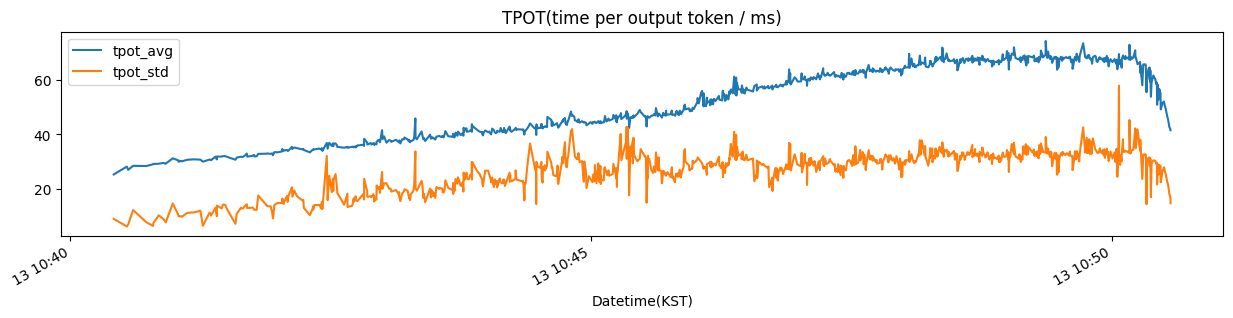

In [133]:
caculated_df.plot(title='TPOT(time per output token / ms)', figsize=(15, 3),
                xlabel = 'Datetime(KST)', x='Datetime(KST)',
                y=['tpot_avg', 'tpot_std'])

<Axes: title={'center': 'TTFT(time to first token)'}, xlabel='Datetime(KST)'>

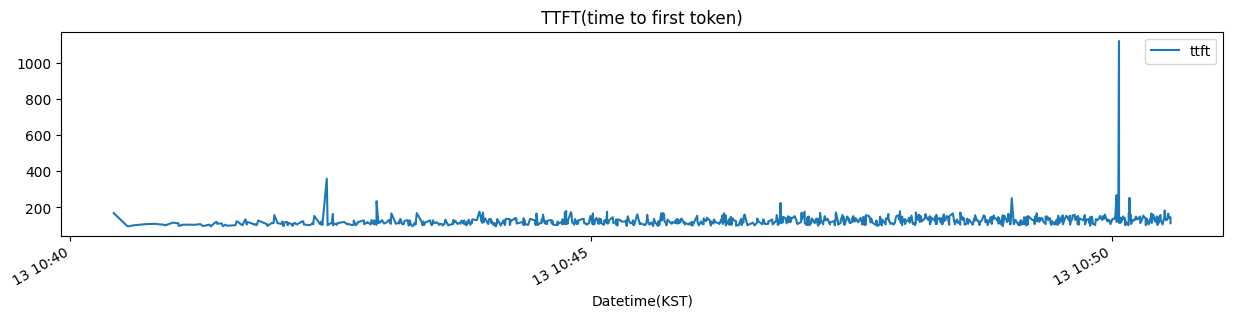

In [130]:
caculated_df.plot(title='TTFT(time to first token)', figsize=(15, 3),
                xlabel = 'Datetime(KST)', x='Datetime(KST)',
                y=['ttft'])

<Axes: title={'center': 'Latency (complete time)'}, xlabel='Datetime(KST)'>

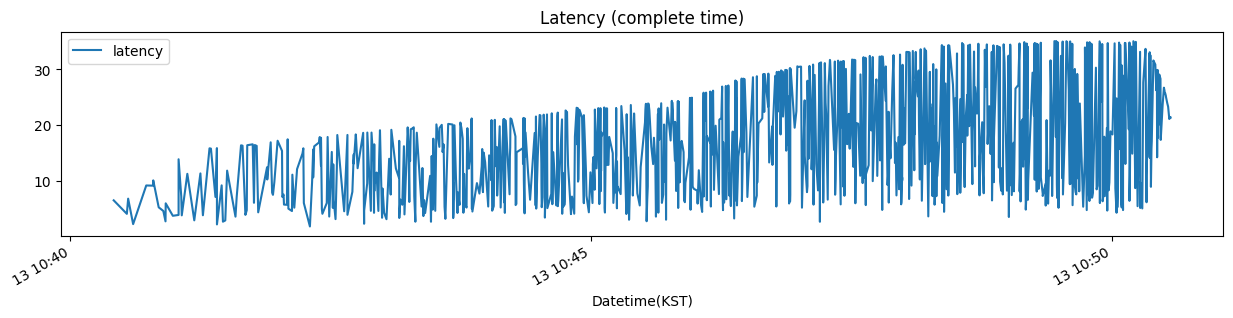

In [131]:
caculated_df.plot(title='Latency (complete time)', figsize=(15, 3),
                xlabel = 'Datetime(KST)', x='Datetime(KST)',
                y=['latency'])

<Axes: title={'center': 'Num of generated token for each request'}, xlabel='Datetime(KST)'>

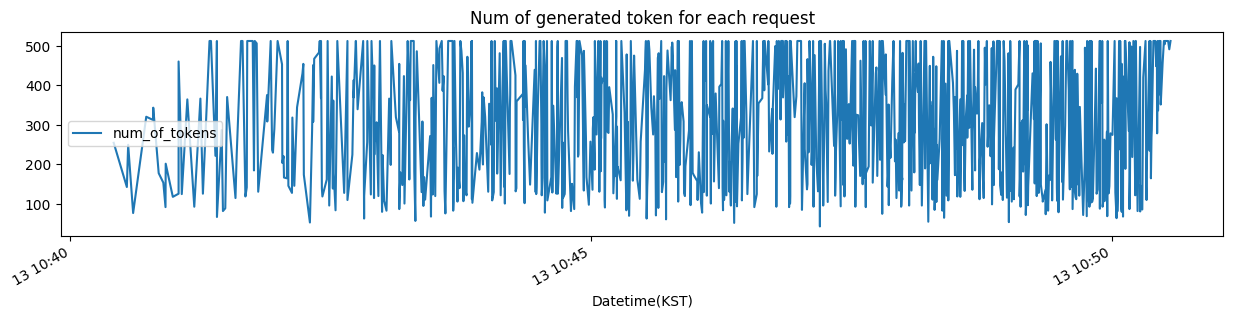

In [132]:
caculated_df.plot(title='Num of generated token for each request', figsize=(15, 3),
                xlabel = 'Datetime(KST)', x='Datetime(KST)',
                y=['num_of_tokens'])

/var/folders/09/nrd0f7kd5rj1ds8c7s02dwwr16q1m1/T/ipykernel_92390/2621778371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_df['Datetime(KST)'] = tokens_df['epoch_time'].map(lambda x: datetime.fromtimestamp(x / 1000).replace(microsecond=0))


<Axes: title={'center': 'Tokens per second (total)'}, xlabel='Datetime(KST)', ylabel='Tokens per second'>

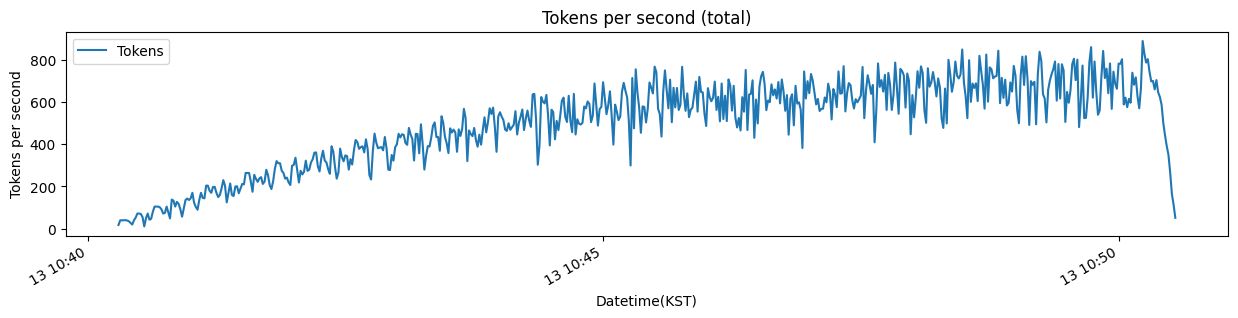

In [175]:
tokens_df = log_df[log_df['message1'].str.contains('Token received :') == True]
tokens_df['Datetime(KST)'] = tokens_df['epoch_time'].map(lambda x: datetime.fromtimestamp(x / 1000).replace(microsecond=0))

tokens_df = tokens_df.groupby('Datetime(KST)')['epoch_time'].count().reset_index()
tokens_df = tokens_df.rename(columns={'epoch_time': 'Tokens'})

tokens_df.plot(title = 'Tokens per second (total)', figsize = (15,3),
                xlabel = 'Datetime(KST)', x ='Datetime(KST)',
                ylabel='Tokens per second', y=['Tokens'],
                )

<Axes: xlabel='Datetime(KST)', ylabel='Tokens'>

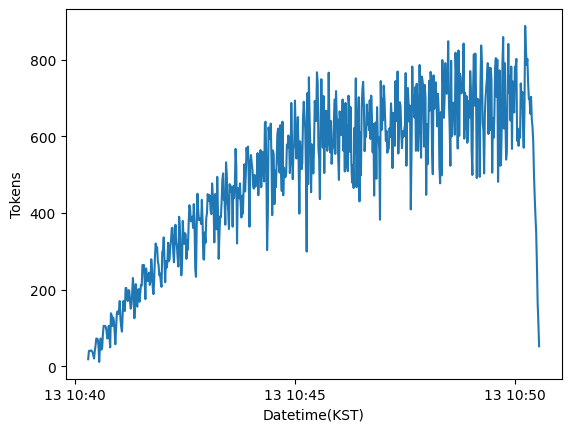

In [187]:
import seaborn as sns

# sns.regplot(data = tokens_df, x = 'Datetime(KST)', y = 'Tokens', )
# sns.displot(data = tokens_df, x = 'Datetime(KST)', y = 'Tokens',)
sns.lineplot(data = tokens_df, x = 'Datetime(KST)', y = 'Tokens',)